<a href="https://colab.research.google.com/github/mohammedbentiress/Sentiment-Analysis/blob/master/Glove_embedding_LSTM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/gdrive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/gdrive


# Importing Required Libraries

In [0]:
import csv
import numpy as np
import pandas as pd
from numpy import array
from numpy import zeros
from numpy import asarray
import matplotlib.pyplot as plt
from tensorflow.keras import Sequential
from tensorflow.keras.models import save_model
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.text import one_hot
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.layers import Activation, Dropout, Dense, Flatten, GlobalMaxPool1D, Embedding, Conv1D, LSTM, GRU,Bidirectional,SpatialDropout1D

# define functions for treatement

**extracting  data from dataset tweet-sentiment**

In [0]:
def load_dataset(filename):
    # read the dataset 
    tweets = pd.read_csv(filename, encoding="ISO-8859-1")

    # tweet listing
    text = []
    sentences = list(tweets['tweet'].astype(str))
    for sen in sentences:
        text.append(sen)

    # sentiment listing
    label = tweets['sentiment']
    label = np.array(list(map(lambda x: 1 if x=="positive" else 0, label)))
    
    return text,label

**load the embedding model**

In [0]:
def load_embedding(filename):
    # create the  embedding dictionnary
    embeddings_dict = dict()
    emb_file = open(filename, encoding='utf8')
    for line in emb_file:
        records = line.split()
        word = records[0]
        vector_dimensions = asarray(records[1:], dtype='float32')
        embeddings_dict [word] = vector_dimensions
    emb_file.close()
    return embeddings_dict

**create embedding weights**

In [0]:
def create_embedding_matrix(embedding, vocabulary):
    # create the feature matrix with filtrinng the element with non zero vector
    count = 0
    vocab_size = len(vocabulary) + 1 
    embedding_mat = zeros((vocab_size, 100))
    for word, index in vocabulary.items():
        embedding_vector = embedding.get(word)
        if embedding_vector is not None:
            count = count + 1
            embedding_mat[index] = embedding_vector
    # print some informations about our vocabulary
    print(" vocabulary size : number of unique words in the vocabulary ",vocab_size)
    print(" percentage of the vocabulary covered by the pretrained model : ",(count/vocab_size)*100)
    return embedding_mat

**create the sentiment classifier**

In [0]:
def create_classifier(classification_model,embeddings):
    # add layers
    classification_model.add(embeddings)
    classification_model.add(Bidirectional(LSTM(100)))
    classification_model.add(Dense(100, activation='relu'))
    classification_model.add(Dense(1, activation='sigmoid'))
    
    # compile 
    classification_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['acc'])
    
    # print summary of the model
    print(classification_model.summary())
    return classification_model

**drawing plots for modeling accuracy and loss of the validation set**

In [0]:
def draw_plots(model_history):
    
    # accuracy plot
    plt.plot(model_history.history['acc'])
    plt.plot(model_history.history['val_acc'])
    plt.title('model accuracy')
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['train','valid'], loc='upper left')
    plt.show()

    # loss plot
    plt.plot(model_history.history['loss'])
    plt.plot(model_history.history['val_loss'])
    plt.title('model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train','valid'], loc='upper left')
    plt.show()

**save dictionnary**

In [0]:
def create_csv(file):
    with open(file, 'w') as csvfile:
        writer = csv.writer(csvfile)
        for key in tokenizer.word_index.keys():
            writer.writerow([key,tokenizer.word_index[key]])

# creating the model by using the functions above 

First we unzip the file that contains tweets

In [0]:
import zipfile
path_to_zip_file= "/content/gdrive/My Drive/PFA/Sentiment-Analysis/Data/clean_tweets.zip"
directory_to_extract_to="/content/gdrive/My Drive/PFA/Sentiment-Analysis/Data/clean_tweets.csv"
with zipfile.ZipFile(path_to_zip_file, 'r') as zip_ref:
    zip_ref.extractall(directory_to_extract_to)

We need to divide our dataset into train and test sets. The train set will be used to train our deep learning models while the test set will be used to evaluate how well our model performs.

We can use train_test_split method from the sklearn.model.selection module

In [0]:
# get the tweets and their sentiment
dataset_file ="/content/gdrive/My Drive/PFA/Sentiment-Analysis/Data/clean_tweets.csv/clean_tweets.csv"
X,y = load_dataset(dataset_file)

# splitting data 
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=42)
Sentences_train = X_train

**Preparing the Embedding Layer**

As a first step, we will use the Tokenizer class from the keras.preprocessing.text module to create a word-to-index dictionary. In the word-to-index dictionary, each word in the corpus is used as a key, while a corresponding unique index is used as the value for the key.

In [0]:
tokenizer = Tokenizer(oov_token = True)
tokenizer.fit_on_texts(X_train)
X_train = tokenizer.texts_to_sequences(X_train)
X_test = tokenizer.texts_to_sequences(X_test)

You will notice that the size of each list is different. This is because sentences have different lengths.

We set the maximum size of each list to 100. You can try a different size. The lists with size greater than 100 will be truncated to 100. For the lists that have length less than 100, we will add 0 at the end of the list until it reaches the max length. This process is called padding.

The following script finds the vocabulary size and then perform padding on both train and test set.

In [0]:
maxlen = 100 
X_train = pad_sequences(X_train, padding='post', maxlen=maxlen)
X_test = pad_sequences(X_test, padding='post', maxlen=maxlen)

We will use GloVe embeddings to create our feature matrix. In the following script we load the GloVe word embeddings and create a dictionary that will contain words as keys and their corresponding embedding list as values.

In [15]:
glove_file = '/content/gdrive/My Drive/PFA/Sentiment-Analysis/GLOVE/glove.6B.100d.txt'
embeddings_dictionary = load_embedding(glove_file)
embedding_matrix = create_embedding_matrix(embeddings_dictionary, tokenizer.word_index)

# create embedding layer
embedding_layer = Embedding(len(tokenizer.word_index)+1, 100, weights=[embedding_matrix], input_length=maxlen, trainable=True)

 vocabulary size : number of unique words in the vocabulary  228200
 percentage of the vocabulary covered by the pretrained model :  39.260297984224366


**Text Classification with Recurrent Neural Network**

Recurrent neural network is a type of neural networks that is proven to work well with sequence data. Since text is actually a sequence of words, a recurrent neural network is an automatic choice to solve text-related problems. In this section, we will use an LSTM (Long Short Term Memory network) which is a variant of RNN, to solve sentiment classification problem.

In [16]:
# create the classifier : convolutional neural network 
model = Sequential()
model = create_classifier(model,embedding_layer)

# evaluating the model :  validation-20% from the training set 
history = model.fit(X_train, y_train, batch_size=1500, epochs=5, verbose=1, validation_split=0.2)

# evaluating the model : test set 20% from the whole dataset 
print("Evaluating the test set")
score = model.evaluate(X_test, y_test, verbose=1)

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 100, 100)          22820000  
_________________________________________________________________
bidirectional (Bidirectional (None, 200)               160800    
_________________________________________________________________
dense (Dense)                (None, 100)               20100     
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 101       
Total params: 23,001,001
Trainable params: 23,001,001
Non-trainable params: 0
_________________________________________________________________
None
Epoch 1/5
683/683 [==============================] - 328s 480ms/step - loss: 0.4581 - acc: 0.7825 - val_loss: 0.4229 - val_acc: 0.8042
Epoch 2/5
683/683 [==============================] - 323s 473ms/step - loss: 0.3978 - acc: 0.8190 - va

In the scipt above, we use the fit method to train our neural network. Notice we are training on our train set only. The validation_split of 0.2 means that 20% of the training data is used to find the training accuracy of the algorithm.

To evaluate the performance of the model, we can simply pass the test set to the evaluate method of our model.

To check the test accuracy and loss, execute the following script:

In [17]:
print("Test Score    :", score[0])
print("Test Accuracy :", score[1])

Test Score    : 0.4486716389656067
Test Accuracy : 0.8093405961990356


Let's try to plot the accuracy differences for training and test sets.

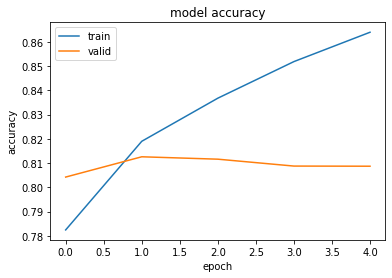

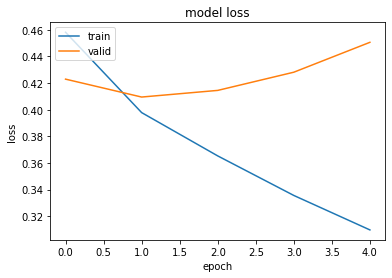

In [18]:
draw_plots(history) 

**Making Predictions on diffrente tweets** 

To predict the sentiment of this tweets, we have to convert this tweets into numeric form. We can do so using the tokenizer that we created in word embedding section. The text_to_sequences method will convert the sentence into its numeric counter part.

Next, we need to pad our input sequence as we did for our corpus. Finally, we can use the predict method of our model and pass it our processed input sequence

In [19]:
txt = ["awesome movie","terrible movie","that movie really sucks","i like that movie"]
txt = tokenizer.texts_to_sequences(txt)
txt = pad_sequences(txt, padding='post', maxlen=maxlen)
prediction = model.predict(txt)
print('\n prediction for \n',prediction[:,0])


 prediction for 
 [0.99538344 0.08622628 0.0138272  0.89108914]


**Saving Model and Dictionnary**

In [0]:
# save model and weights
save_model(
    model,
    "/content/gdrive/My Drive/PFA/Sentiment-Analysis/TrainedModels/GLOVE/model_LSTM_glove100.h5",
    overwrite=True,
    include_optimizer=True
)

# save vocabulary dictionnary
#create_csv('/content/gdrive/My Drive/PFA/Sentiment-Analysis/TrainedModels/GLOVE/dict_sentimentAnalysis.csv')
